# Detection des visages

Une fois le visage est détecté, nous nous intéressons à le reconnaître. Dans cette section nous supposons qu’ondispose d’images de visages (c.a.d la phase de détection a été déjà réalisée). L’objectif est de reconnaîtrel’identité de chaque visage. Nous allons explorer des approches classiques et des approches CNN

Pour cette partie voila la liste des site que l'on c'est inspiré pour la réalisation de ce projet:
- [Face Detection CNN](https://www.kaggle.com/code/nurcankurt/face-detection-cnn)
- [Détection de Masque Visage utilisant CNN (98% Précision)](https://www.kaggle.com/code/arbazkhan971/face-mask-detection-using-cnn-98-accuracy)
- [face-mask-detection CNN](https://www.kaggle.com/code/abdalrahmanshahrour/face-mask-detection-cnn/notebook)
- [Face detection using CNN with the LFW dataset](https://www.kaggle.com/code/jake126/face-detection-using-cnn-with-the-lfw-dataset)
- [Image Recognition - Gender Detection](https://www.kaggle.com/code/bmarcos/image-recognition-gender-detection-inceptionv3)
- [Face-Detection-Dataset](https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset?resource=download-directory)

In [70]:
# bibliotheque utiliser pour les expressions regulieres
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import random
import seaborn as sns
import cv2

Evitons d'entrainer nos ia sur un dataset ou il y a une grande mojorité de visage d'une seul personne pour éviter le biais de l'ia.
De ce fait nous observons d'abord le datatset et nous le nettoyons pour avoir un dataset équilibré.


In [71]:
# Charger les données de visage LFW
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names

(904, 2914)


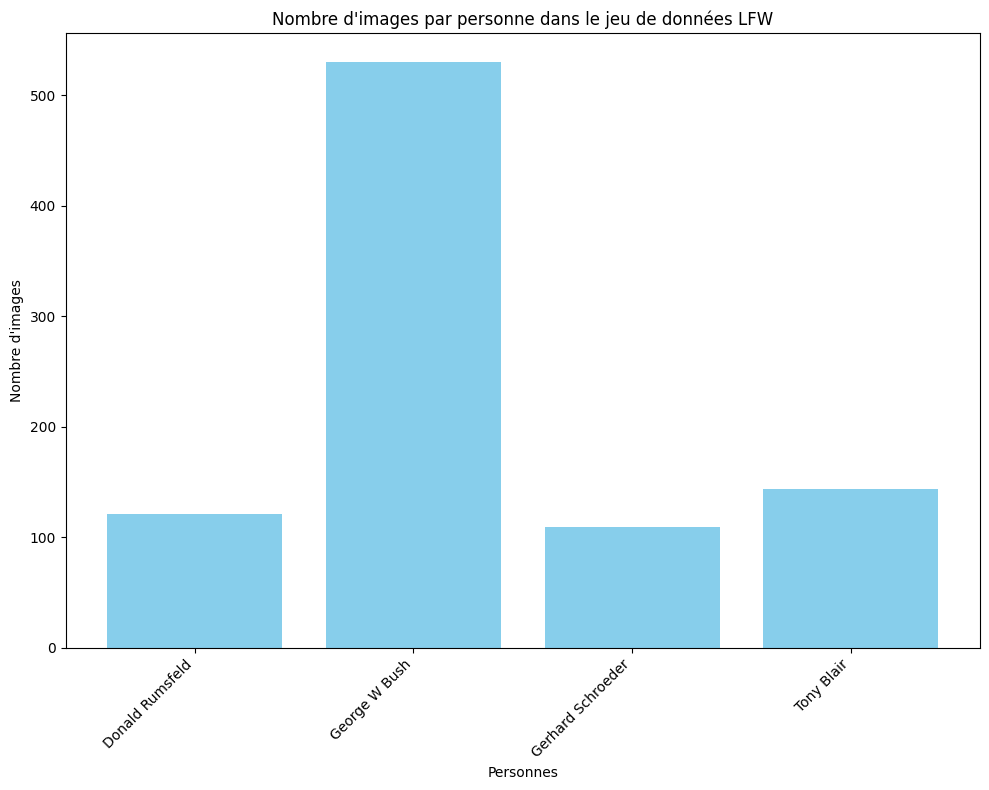

In [72]:
# Affichage de la taille des données
print(X.shape)

import matplotlib.pyplot as plt
import numpy as np

# Compter le nombre d'occurrences de chaque cible
counts = np.bincount(y)

# Créer le graphique à barres
plt.figure(figsize=(10, 8))
plt.bar(target_names, counts, color='skyblue')
plt.xlabel('Personnes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par personne dans le jeu de données LFW')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

On remarque que le dataset est déséquilibré, il y a une grande majorité de visage d'une seule personne. Nous allons donc équilibrer le dataset en supprimant les visages de la personne qui apparaît le plus de fois.

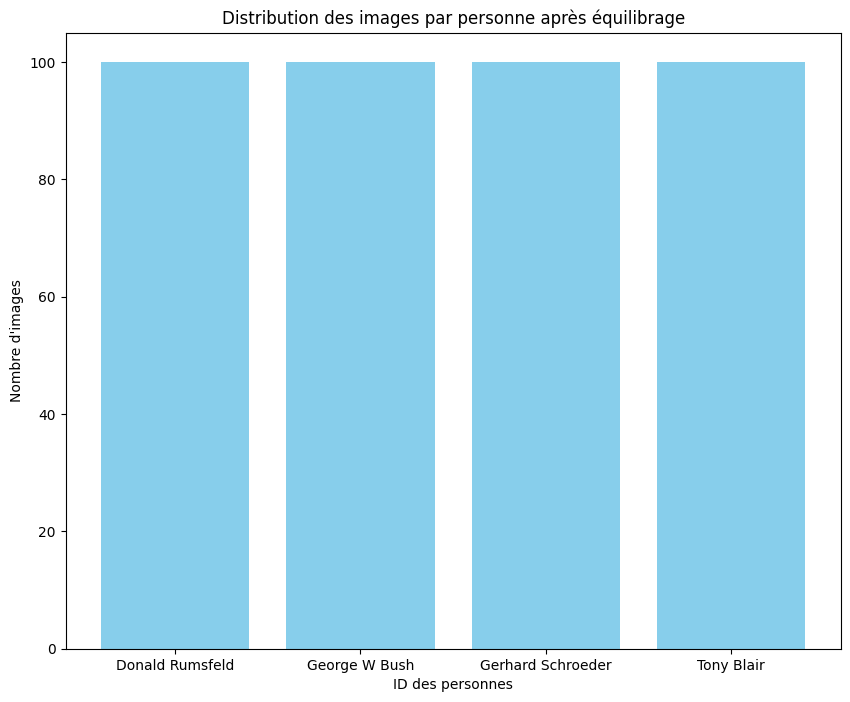

In [73]:
import numpy as np

# Initialiser les listes pour stocker les données ajustées
X_ajuste = []
y_ajuste = []

# Identifier toutes les personnes uniques
personnes_uniques = np.unique(y)

# Pour chaque personne, ajuster le nombre d'images
for personne in personnes_uniques:
    indices = np.where(y == personne)[0]
    if len(indices) > 100:
        indices = indices[:100]  # Limiter à 100 images si plus disponible
    X_ajuste.append(X[indices])
    y_ajuste.append(y[indices])

# Combiner les données ajustées
X_ajuste = np.concatenate(X_ajuste, axis=0)
y_ajuste = np.concatenate(y_ajuste, axis=0)

# Vérifier la nouvelle distribution des classes
nouvelles_counts = np.bincount(y_ajuste)
plt.figure(figsize=(10, 8))
plt.bar(target_names, nouvelles_counts, color='skyblue')
plt.xlabel('ID des personnes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par personne après équilibrage')
plt.show()

# Mettre à jour X et y avec les données ajustées
X = X_ajuste
y = y_ajuste

## Programme pour reconnaître un visage (ACP)

Ecrire un programme Python permettant de reconnaitre un visage en utilisant l’ACP


In [74]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# Appliquer l'ACP pour réduire la dimensionnalité des données de visage
n_components = 150  # nombre de composantes principales
pca = PCA(n_components=n_components, whiten=True, random_state=42)
pca.fit(X_train)

PCA(n_components=150, random_state=42, whiten=True)

In [76]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Entraîner un classifieur sur les données réduites
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_pca, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = clf.predict(X_test_pca)

Classification Report for ACP:
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.62      0.27      0.38        37
    George W Bush       0.35      0.72      0.47        25
Gerhard Schroeder       0.82      0.30      0.44        30
       Tony Blair       0.41      0.61      0.49        28

         accuracy                           0.45       120
        macro avg       0.55      0.47      0.44       120
     weighted avg       0.57      0.45      0.44       120

[[10 14  1 12]
 [ 2 18  0  5]
 [ 4 10  9  7]
 [ 0 10  1 17]]
(62, 47)


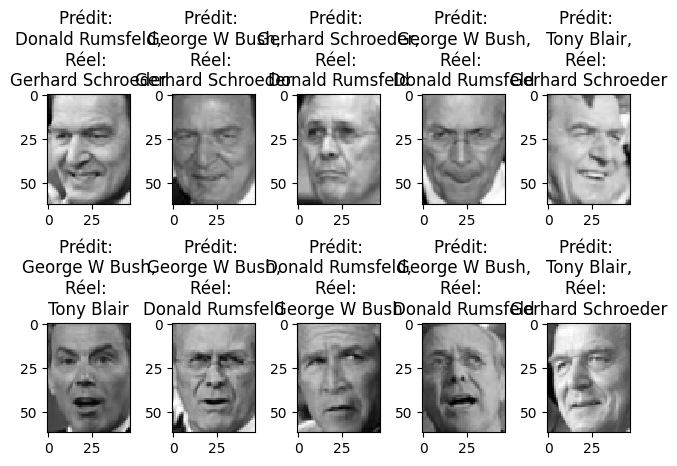

In [77]:
# Évaluer la performance du modèle
print("Classification Report for ACP:")
print(classification_report(y_test, y_pred, target_names=target_names))

print(confusion_matrix(y_test, y_pred))

# Afficher les 6 premieres images qui ont été mal classées
import matplotlib.pyplot as plt
import numpy as np

# Trouver les indices des prédictions incorrectes
incorrect_indices = np.where(y_pred != y_test)[0]

# Sélectionner les premiers indices incorrects
indices = 10
row = 2
col = indices // row
first_incorrect = incorrect_indices[:indices]

# Calculer la taille correcte pour le redimensionnement
image_size = lfw_dataset.images.shape[1:3]
print(image_size)

# Afficher les 6 premières images mal classées
for i, incorrect_index in enumerate(first_incorrect, start=1):
    plt.subplot(row, col, i)
    # Utiliser la taille calculée pour le redimensionnement
    plt.imshow(X_test[incorrect_index].reshape(image_size[0], image_size[1]), cmap='gray', interpolation='none')
    plt.title(f"Prédit: \n{target_names[y_pred[incorrect_index]]},\nRéel: \n{target_names[y_test[incorrect_index]]}")
    plt.tight_layout()

# Enregistrer le graphique sous le nom 'erreur.png'
plt.savefig('./out/ACP/analyse/erreur.png', bbox_inches='tight')
plt.show()

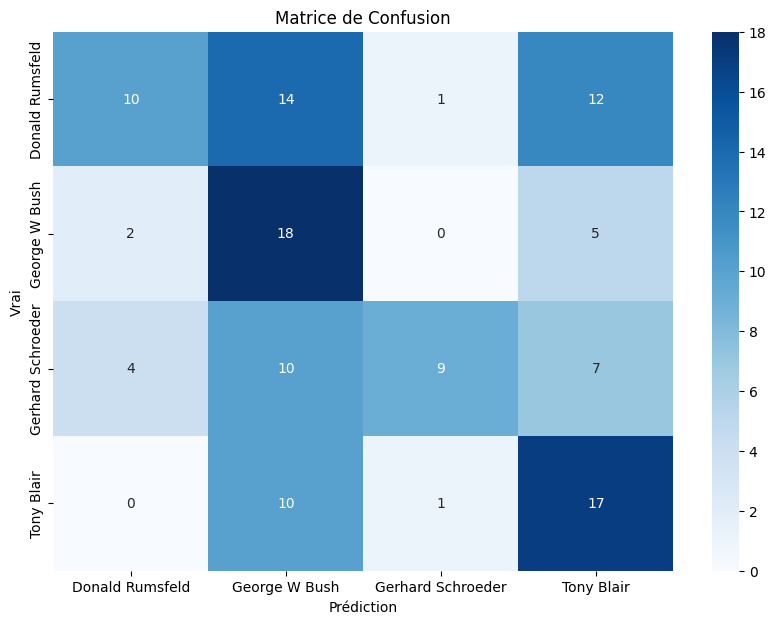

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(class_names, y_test, y_pred):
    # Calculer la matrice de confusion
    confusion_matrix_2d = confusion_matrix(y_test, y_pred)

    # Créer un heatmap avec la matrice de confusion 2D
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix_2d, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Ajouter des titres et des étiquettes
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vrai')

    # Afficher le graphique
    plt.show()

plot_confusion_matrix(target_names, y_test, y_pred)

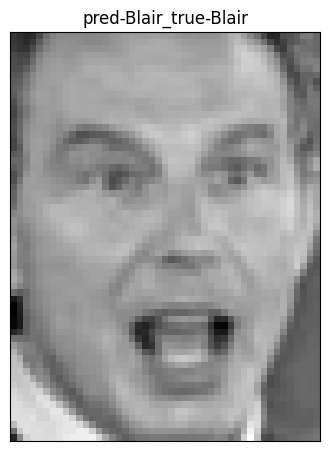

True

In [79]:
# Afficher un résultat de reconnaissance de visage
def plot_single_image(image, title, h, w):
    plt.figure(figsize=(4, 6))
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(title, size=12)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Préparer le titre pour l'image prédite
def single_title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'pred-%s_true-%s' % (pred_name, true_name)

# Afficher une seule image avec son titre
h, w = lfw_dataset.images.shape[1:3]
i = random.randint(0, len(X_test) - 1)  # Choisir un index aléatoire
title = single_title(y_pred, y_test, target_names, i)
plot_single_image(X_test[i], title, h, w)

titleFile = single_title(y_pred, y_test, target_names, i)

# Convertir l'image de la plage [0, 1] à [0, 255] et changer le type en entier
image_to_save = (X_test[i].reshape((h, w)) * 255).astype('uint8')
cv2.imwrite(f'./out/ACP/{titleFile}.jpg', image_to_save)

## Les caracteristique de HOG

Ecrire un programme Python permettant de calculer les caractéristiques de HOG d’une image.

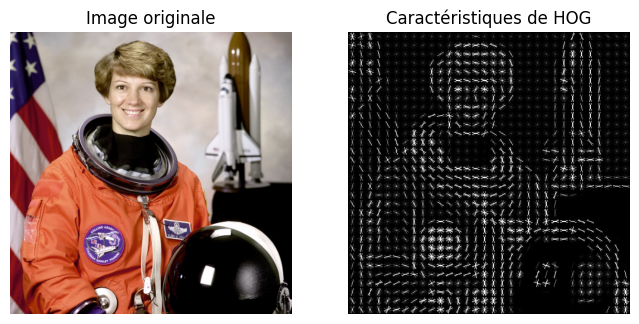

In [80]:
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

# Charger une image exemple
image = data.astronaut()

# Calculer les caractéristiques de HOG
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# Ajuster le contraste de l'image HOG pour une meilleure visualisation
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Afficher l'image originale et l'image HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Image originale')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Caractéristiques de HOG')

plt.show()

## HOG + DecisionTree et HOG + Random Forest

Ecrire un programme Python permettant de reconnaitre un visage en utilisant les descripteurs de HOG etles classifieurs arbre de décision et RandomForest. Ainsi, on distingue deux méthodes : HOG + DecisionTree et HOG + Random Forest

In [81]:
# Importation des bibliothèques nécessaires
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_reshaped = image.reshape((62, 47))  # Redimensionner l'image à sa taille originale
        # Mise à jour de l'appel à la fonction hog sans l'argument multichannel
        fd = hog(image_reshaped, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=False)
        hog_features.append(fd)
    return hog_features

# Extraction des descripteurs HOG pour les ensembles d'entraînement et de test
X_hog = extract_hog_features(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.3, random_state=42)

### Entraînement et évaluation avec DecisionTree

Classification Report for Decision Tree:
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.50      0.41      0.45        37
    George W Bush       0.60      0.48      0.53        25
Gerhard Schroeder       0.56      0.60      0.58        30
       Tony Blair       0.34      0.46      0.39        28

         accuracy                           0.48       120
        macro avg       0.50      0.49      0.49       120
     weighted avg       0.50      0.48      0.49       120



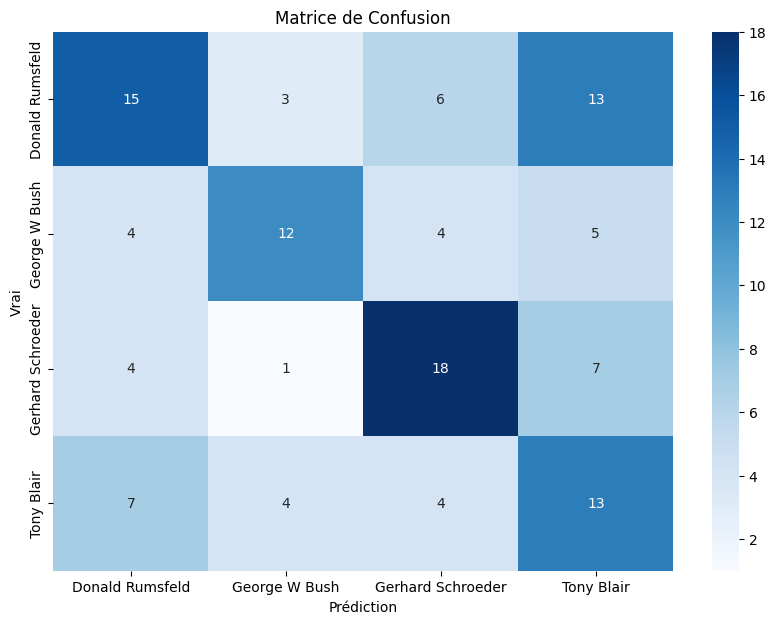

In [82]:
# Entraînement et évaluation avec DecisionTree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
plot_confusion_matrix(target_names, y_test, y_pred_dt)

### Entraînement et évaluation avec RandomForest

Classification Report for Random Forest:
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.69      0.59      0.64        37
    George W Bush       0.43      0.40      0.42        25
Gerhard Schroeder       0.60      0.70      0.65        30
       Tony Blair       0.60      0.64      0.62        28

         accuracy                           0.59       120
        macro avg       0.58      0.58      0.58       120
     weighted avg       0.59      0.59      0.59       120



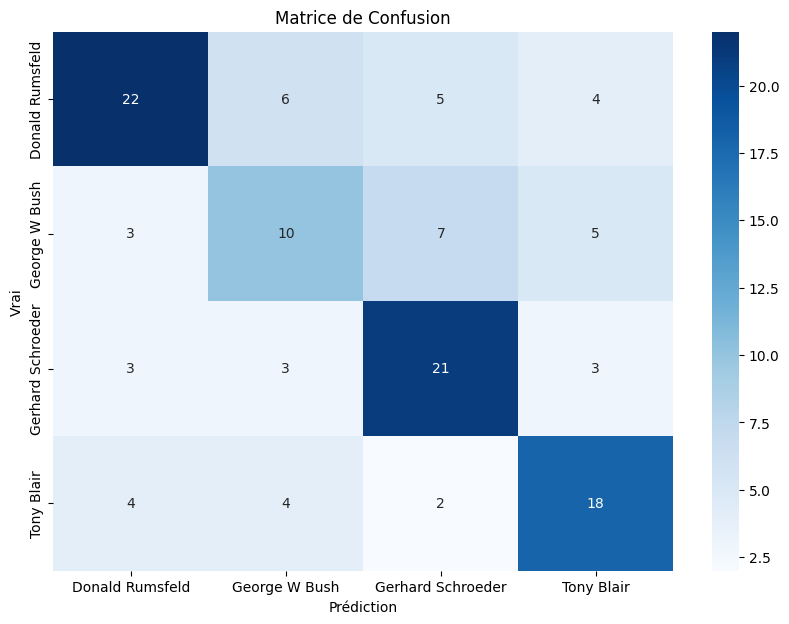

In [83]:
# Entraînement et évaluation avec RandomForest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
plot_confusion_matrix(target_names, y_test, y_pred_rf)

## CNN

Ecrire un programme Python permettant de reconnaitre un visage en utilisant une architecture CNN


In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Redimensionner les données pour les adapter à l'entrée du CNN
X_train_cnn = X_train.reshape(-1, 62, 47, 1)
X_test_cnn = X_test.reshape(-1, 62, 47, 1)

# Créer un modèle CNN simple
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(62, 47, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50

# Entraîner le modèle
historique = model.fit(X_train_cnn, y_train, epochs=epochs, batch_size=64, validation_split=0.1)

# Évaluer le modèle
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print(f'Précision du modèle CNN: {test_acc}')

Epoch 1/50


C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.1763 - loss: 1.8866 - val_accuracy: 0.3214 - val_loss: 1.5544
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2238 - loss: 1.7224 - val_accuracy: 0.2857 - val_loss: 1.4966
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2495 - loss: 1.6497 - val_accuracy: 0.3214 - val_loss: 1.5338
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3075 - loss: 1.5881 - val_accuracy: 0.3214 - val_loss: 1.4525
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2432 - loss: 1.6438 - val_accuracy: 0.3214 - val_loss: 1.4635
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2349 - loss: 1.5881 - val_accuracy: 0.2857 - val_loss: 1.4560
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1988 - loss: 1.6049 - val_accuracy: 0.3214 - val_loss: 1.4227
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2875 - loss: 1.5184 - val_accuracy: 0.3214 - val_loss: 1.4135
Epoch 9/

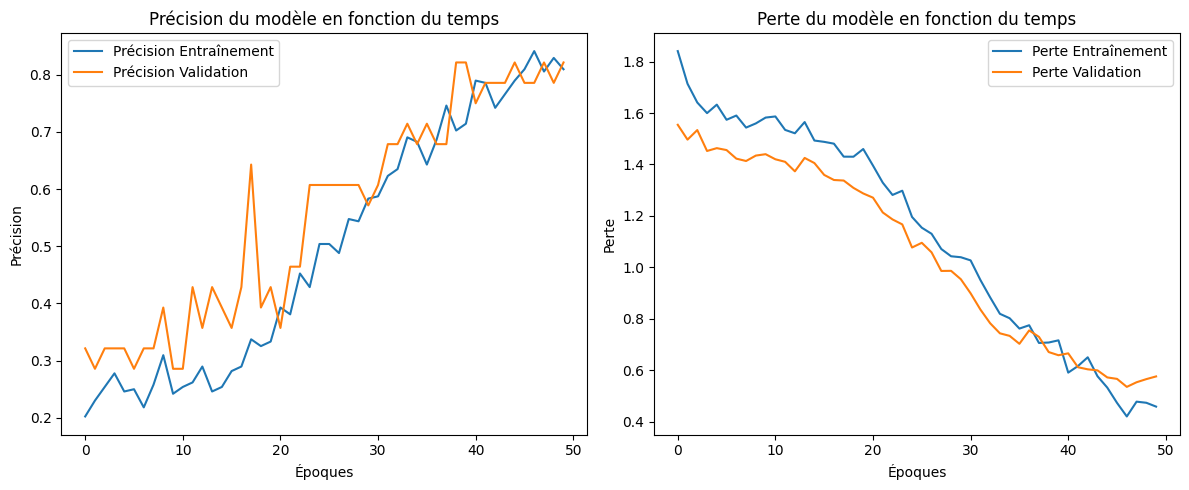

In [85]:
import matplotlib.pyplot as plt

# Tracer la précision d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(historique.history['accuracy'], label='Précision Entraînement')
plt.plot(historique.history['val_accuracy'], label='Précision Validation')
plt.title('Précision du modèle en fonction du temps')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la perte d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(historique.history['loss'], label='Perte Entraînement')
plt.plot(historique.history['val_loss'], label='Perte Validation')
plt.title('Perte du modèle en fonction du temps')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Classification Report for CNN:
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.89      0.84      0.86        37
    George W Bush       0.92      0.88      0.90        25
Gerhard Schroeder       0.79      0.77      0.78        30
       Tony Blair       0.72      0.82      0.77        28

         accuracy                           0.82       120
        macro avg       0.83      0.83      0.83       120
     weighted avg       0.83      0.82      0.83       120



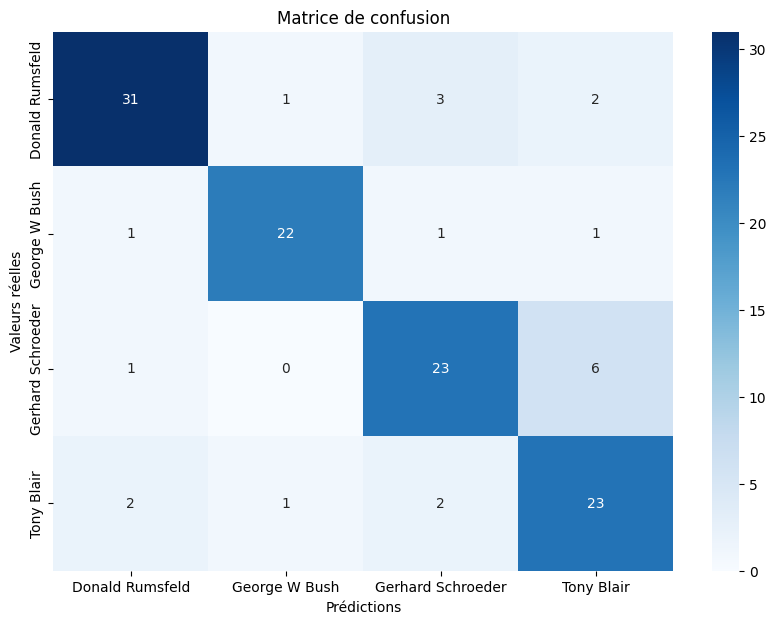

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Prédire les étiquettes pour l'ensemble de test
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Affichage du classification report
print("Classification Report for CNN:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Calculer la matrice de confusion
mat_conf = confusion_matrix(y_test, y_pred_classes)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(mat_conf, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

##  Interpréter les résultats obtenus

Notre rapport de classification pour les différents modèles (ACP, Arbre de décision, Forêt aléatoire, CNN) montrent des performances variées sur le dataset de reconnaissance de visages. Voici notre interprétation des résultats :

### ACP (Analyse en Composantes Principales)

Ce modèle a une précision globale de 45%. Il montre une faible performance sur presque toutes les classes, en particulier pour Donald Rumsfeld et Gerhard Schroeder, indiquant une difficulté à distinguer efficacement entre les différentes personnes. La précision est relativement meilleure pour Gerhard Schroeder, mais avec un faible rappel.

### Arbre de décision

L'arbre de décision améliore légèrement la précision globale à 48%. Il montre une meilleure équilibre entre précision et rappel par rapport à l'ACP, indiquant une capacité légèrement meilleure à généraliser sur les différentes classes. Cependant, les performances restent modérées.

### Forêt aléatoire

La forêt aléatoire montre une amélioration significative avec une précision globale de 59%. Ce modèle offre un meilleur équilibre entre précision et rappel pour toutes les classes, en particulier pour Gerhard Schroeder et Tony Blair, ce qui suggère une meilleure capacité à distinguer les différentes personnes.

### CNN (Réseau de Neurones Convolutifs)

Le CNN présente les meilleures performances avec une précision globale de 82%. Il montre une haute précision et un bon rappel pour toutes les classes, indiquant une excellente capacité à reconnaître et distinguer entre les différentes personnes. Cela reflète l'efficacité des CNN pour les tâches de reconnaissance d'images, en particulier dans des contextes complexes comme la reconnaissance de visages.

### Conlusion

Les résultats montrent clairement que les modèles basés sur l'apprentissage profond, comme les CNN, surpassent les approches traditionnelles et les modèles basés sur les arbres pour la reconnaissance de visages. Les CNN offrent une meilleure capacité à extraire et à apprendre des caractéristiques discriminantes des images, ce qui se traduit par une meilleure précision et un meilleur rappel. Cela souligne l'importance de choisir des architectures de modèles adaptées à la nature des données et à la complexité de la tâche.
